# Seminar 3 - Numerical Issues

The unit so far has introduced how algorithms can be implemented in a programming language to solve mathematical problems.

Generally, if you use a computer algoruthm to solve a problem, instead of working something out by analysis, we call it a **numerical method**.

> Example: find the a root of $ax^2 + bx + c = 0$.  An analytical method would be the known formula $x = \frac{-b \pm \sqrt{b^2-4ac}}{2a}$.  A numerical method would be to run a bisection search.

This seminar will cover some of the limitations of using a computer to do maths.  We often refer to these as **numerical issues**.  In particular, this seminar will explore three "gotchas":
 - Truncation
 - Conditioning
 - Time stepping




## Truncation

Let's begin with an example.  Think of a number...

In [77]:
a = 1e-12

Now add one million to that number...

In [78]:
b = a + 1000000

Take away one million...

In [79]:
c = b - 1000000

And you should be back where you started, right?

In [80]:
print('a was',a)
print('b was',b)
print('c is',c)

a was 1e-12
b was 1000000.0
c is 0.0


Where did my 1e-12 go?  It was important to someone...

To understand, recall how floating point numbers are stored

#### Floating point binary numbers

Binary **floating point** number storage is similar to *scientific notation* for decimal (base-10) values, but with:
- a *binary* **mantissa** (normalised so that a maximum of 1 significant figure (s.f.) is to the left of the decimal point) 
- a *binary* **exponent** (whole number, no decimal point)
- a **base** of 2


$
\boxed{\underbrace{M}_{mantissa} \times \underbrace{2}_{base}\overbrace{^E}^{exponent}}
$


- $
1.25 = 1\frac{1}{4} \times 2^0 
\textrm{ written as 4-bit mantissa }    \boxed{ \underbrace{1}_{1}.\underbrace{0}_{\frac{1}{2}}\underbrace{1}_{\frac{1}{4}}\underbrace{0}_{\frac{1}{8}} } 
\textrm{ and 2-bit exponent }   \boxed{ \underbrace{0}_{2}\underbrace{0}_{1} }
$
- $
5.5 = 1\frac{3}{8} \times 2^2 
\textrm{ written as 4-bit mantissa }    \boxed{ \underbrace{1}_{1}.\underbrace{0}_{\frac{1}{2}}\underbrace{1}_{\frac{1}{4}}\underbrace{1}_{\frac{1}{8}} } 
\textrm{ and 2-bit exponent }   \boxed{ \underbrace{1}_{2}\underbrace{0}_{1} }
$
- $
12 = 1\frac{1}{2} \times 2^3 
\textrm{ written as 4-bit mantissa }    \boxed{ \underbrace{1}_{1}.\underbrace{1}_{\frac{1}{2}}\underbrace{0}_{\frac{1}{4}}\underbrace{0}_{\frac{1}{8}} } 
\textrm{ and 2-bit exponent }   \boxed{ \underbrace{1}_{2}\underbrace{1}_{1} }
$

### Floating point arithmetic

To add two numbers, we need to begin by "lining up the digits" _i.e._ moving them to a shared exponent.  For example, using decimal scientific notation, imagine trying to add $1E3$ to $1E-3$.

$(1 \times 10^3) + (1 \times 10^{-3}) = (1 \times 10^3) + (0.000001 \times 10^{3}) = (1 + 0.000001) \times 10^3 = 1.000001\times10^3$

The catch comes at the stage of transforming to $0.000001 \times 10^3$.  If there aren't enough digits on my calculator to write that, the 1 will get chopped off the end - _truncated_ - and the sum gives the result 1.

Something similar, but in binary form, is happening in the computer.  The processor has to move them to a comment exponent to do the add, and then the smaller number gets truncated beyond the last available _bit_.

> **Gotcha #1**: even though the computer can represent small numbers (1E-12) and big numbers (1E6) in memory, it may still struggle to combine them.

Another example, this time multiplying.

$\frac{5}{9}$ is the same as $\frac{1}{3} \times 5 \times \frac{1}{3}$, right?

In [81]:
d = 5/9
e = (1/3)*5*(1/3)
print('d is', d)
print('e is', e)
print('difference is',e-d)
print('equality?',d == e)

d is 0.5555555555555556
e is 0.5555555555555555
difference is -1.1102230246251565e-16
equality? False


Wrong!  At least in a computer setting...

Why? Harder to explain, but the order of calculation will hit slightly different truncation errors, so the final results will be slightly different.

General rule: never use exact comparison with floating point numbers.  One of the in-class examples looked at checking if two numbers are close, and Python even provides a function for this in the `math` library.

In [82]:
from math import isclose
print('close?',isclose(d,e))

close? True


## Conditioning

Many numerical algorithms involve solving large matrix equations.  They turn up in gradient descent algorithms for training AI models and in curve fitting for identifying trends in data.  We'll use an example of the latter to show some limitations.

First, import `numpy`, a very handy matrix library for Python that will turn up again later.

In [83]:
import numpy

In this example, we will define a function and take three samples from it.  Then we'll pretend we don't know the function, and try and fit a curve to the data, and use that curve to predict the function value at a fourth location.  All being well, the function and the predictor should give the same answer.

Start by defining the function, with the boring name `f`:

In [84]:
def f(x):
    return 2 + 3*x + 4*x*x

Now define three points, $x \in \{0,0.5,1\}$ and find the function values at each.  These are our _samples_ or _training data_ if you like. 

In [85]:
x1 = 0
y1 = f(x1)
x2 = 0.5 #e-12
y2 = f(x2)
x3 = 1
y3 = f(x3)

Now for a clever bit.  We want to fit a curve of the form $y=a+bx+cx^2$.  This means solving the simultaneous equations:

$y_1 = a + bx_1 +cx_1^2$

$y_2 = a + bx_2 +cx_2^2$

$y_3 = a + bx_3 +cx_3^2$

That can be written in matrix form $\mathbf{Mp} = \mathbf{v}$:

$
\left[
    \begin{array}{ccc} 
    1 & x_1 & x_1^2 \\
    1 & x_2 & x_2^2 \\
    1 & x_3 & x_3^2 \\
    \end{array}
\right]
\left(
    \begin{array}{c} 
    a \\
    b \\
    c \\
    \end{array}
\right)=
\left(
    \begin{array}{c} 
    y_1 \\
    y_2 \\
    y_3 \\
    \end{array}
\right)
$

We use the training data to form $\mathbf{M}$ and $\mathbf{v}$ and then find the parameters $a,b,c$ by solving $\mathbf{p}=\mathbf{M}^{-1}\mathbf{v}$

> In practice, it is best to avoid inverting matrices.  It is slow compared to other ways of solving equations like this, but it will be OK for these examples.

Here's the code to do the process above using `numpy`:

In [86]:
M = numpy.array([[1,x1,x1**2],
                 [1,x2,x2**2],
                 [1,x3,x3**2]])
v = numpy.array([y1,y2,y3])
p = numpy.linalg.inv(M)@v
print('a=',p[0],'b=',p[1],'c=',p[2])

a= 2.0 b= 3.0 c= 4.0


Looks good.  Now let's take a test point $x_4 = 0.25$ and compare the curve with the original function.

In [87]:
x4 = 0.25
print('Predicted:',p[0] + p[1]*x4 + p[2]*x4**2,'True:',f(x4))


Predicted: 3.0 True: 3.0


Excellent - they agree.

Now repeat that process but with the middle sample point moved from $0.5$ to $5\times 10^{-13}$ ...  Does it change the answer?

Spoiler: yes it does.  Moving the two points so close makes the process exceptionally sensitive to tiny changes, especially in $y_2$.  While we haven't change it, our old friend truncation error means its value is not represented _perfectly_, and that error is being amplified by the process.

When a matrix problem has this extreme sensitivity, we say it is _ill conditioned_.

> **Gotcha #2**: errors can seem to come from nowhere if the conditioning of the process makes it highly sensitive.

You can test for such vulnerability.  The _conditioning number_ of a matrix can be calculated as an estimate of its sensitivity.  The perfect conditioning number would be $1$.  (It can go no lower because of how it is calculated.)  A large conditioning number indicates potential problems ahead.

In [88]:
numpy.linalg.cond(M)

np.float64(15.099657722502098)

Try the above with both settings for $x_2$ and note the difference.

## Time stepping

The final numerical issue relates to simulation, _i.e._ trying to predict real-world behaviour using a computer model.  The real world runs in continuous time - but a computer has only finite memory so has to break that into discrete _time steps_ to conduct simulations.  That raises some issues, which will be introduced in this section.

> There are some clever tricks to go beyond discrete steps and make some attempt to model the continuous world.  Finite element methods or collocation methods are examples.  But there is no free lunch: these change the problems but don't make them go away.

Example: simulate a unit mass on a spring.

$\ddot{x} = -kx$

Analytically, we know the answer from high school: $x(t)$ should be a sine wave, with frequency $\sqrt{k}$ radians/s. 

To simulate this numerically, we have to break the equation into two, representing the separate _states_ of the system, position $x$ and velocity $v$.

$\frac{dx}{dt} = v(t)$

$\frac{dv}{dt} = -kx(t)$

Then, given initial states $x(0)$ and $v(0)$, we can simulate forwards in time steps $\delta t$ using a simple approximation:

$x(t+\delta t) \approx x(t) + \delta t \times v(t)$

$v(t+\delta t) \approx v(t) + \delta t \times (-kx(t))$

This is called the _forward Euler_ approximation.

Start experiment by defining some constants

In [89]:
# spring stiffness
k = 1
# time step length
dt = 0.01

Now define initial states and time.  We will use Python _lists_ to store all the times and positions visited, `xs=[x1,x2,x3]` _etc_.  More on those soon.  THe code here starts the lists with the initial values only.

In [90]:
# initial states and time
x = 1
v = 0
t = 0
# store for time and position
xs = [x]
ts = [t]

Now run the simulation for 1000 time steps, i.e. ten seconds.

> Have a quick read of the code to get a feel for what it does.

In [91]:
for ii in range(1000):
    # calculate the derivatives
    dx_dt = v
    dv_dt = -k*x
    # apply them for a time step
    x = x + dt*dx_dt
    v = v + dt*dv_dt
    # update time index as well
    t = t + dt
    # print, just to see something happening
    print(t,x,v)
    # add position and time to end of respective lists
    xs.append(x)
    ts.append(t)

0.01 1.0 -0.01
0.02 0.9999 -0.02
0.03 0.9997 -0.029999
0.04 0.99940001 -0.039996000000000004
0.05 0.99900005 -0.0499900001
0.060000000000000005 0.998500149999 -0.0599800006
0.07 0.997900349993 -0.06996500209999
0.08 0.9972006999720001 -0.07994400559992
0.09 0.9964012599160009 -0.08991601259964001
0.09999999999999999 0.9955020997900045 -0.09988002519880002
0.10999999999999999 0.9945032995380165 -0.10983504619670006
0.11999999999999998 0.9934049490760495 -0.11978007919208022
0.12999999999999998 0.9922071482841287 -0.1297141286828407
0.13999999999999999 0.9909100069973003 -0.139636200165682
0.15 0.9895136449956434 -0.14954530023565502
0.16 0.9880181919932869 -0.15944043668561145
0.17 0.9864237876264308 -0.16932061860554432
0.18000000000000002 0.9847305814403754 -0.17918485648180862
0.19000000000000003 0.9829387328755573 -0.1890321622962124
0.20000000000000004 0.9810484112525952 -0.19886154962496796
0.21000000000000005 0.9790597957563455 -0.2086720337374939
0.22000000000000006 0.9769730754

Just looking at the numbers is not very informative, so let's use a plot.  `matplotlib` is good for this - again, more coming soon.

In [92]:
import matplotlib.pyplot as plt

Plot the position against time using our lists.

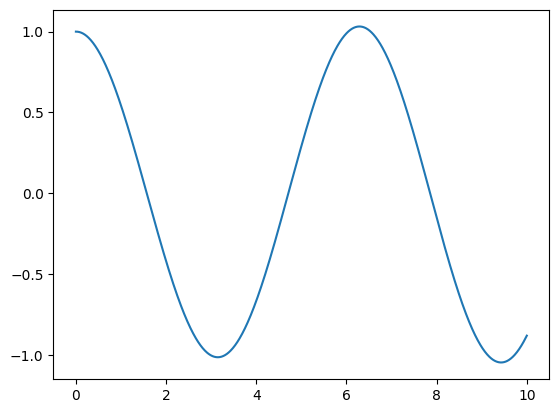

In [93]:
plt.plot(ts,xs)
plt.show()

Looks like a lovely sine wave, or more accurately a cosine wave.

The solution ought to be $x(t) = \cos(\sqrt{k}t) = \cos(t)$.  Plot both for comparison.  `numpy` gives us a helpful `cos` function that will work for all elements of a list.

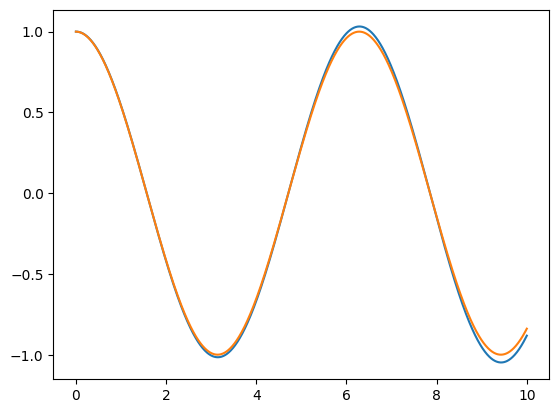

In [94]:
plt.plot(ts,xs)
plt.plot(ts,numpy.cos(ts))
plt.show()

Not perfect, but not too bad.  What if it runs a lot longer?

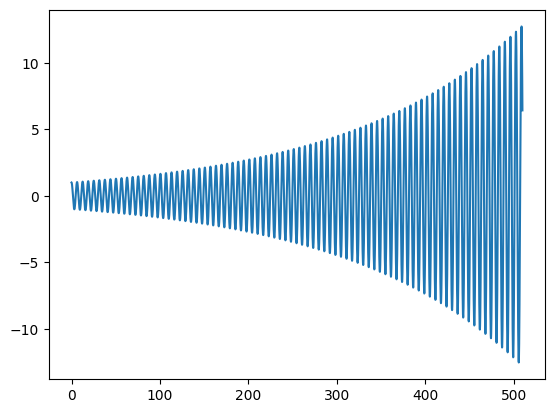

In [95]:
for ii in range(50000):
    dx_dt = v
    dv_dt = -k*x
    x = x + dt*dx_dt
    v = v + dt*dv_dt
    t = t + dt
    xs.append(x)
    ts.append(t)

plt.plot(ts,xs)
plt.show()

Somehow our mass and spring have gone unstable?  That can't be right.

The forward Euler method is known to have potential instability, _i.e._ that the error can grow, unbounded.  The root cause is the approximation: it assumes the derivatives are constant for the time step, whereas in truth they will alter continuously.

> **Gotcha #3** simulated behaviour can be radically different than real life due to approximation by finite steps.

This is the beginning of a very large topic.  Python's `scipy` package includes at least six different methods for solving differential equations like this and Matlab ships with ten.  Different methods are suited to different types of differential equations, and you can study the error characteristics by analysis.  That's well beyond the scope of this seminar.

To end on a happy note, here's the example again but using a [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).  Instead of just using the derivatives from the start of the time step, it computes a series of intermediate derivative values, and then combines them to make a better step.

Start again by initializing the states, time and stores.

In [96]:
# initial states and time
x = 1
v = 0
t = 0
# store for time and position
xs = [x]
ts = [t]

Now the integration.  More lines of code, but nothing dramatically more complicated.

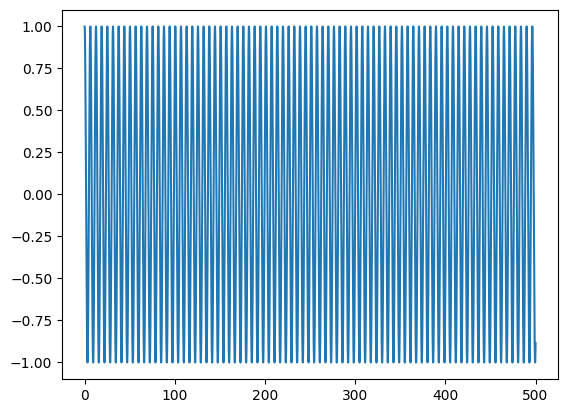

In [97]:
for ii in range(50000):
    # derivative from start of step
    dx_dt_1 = v
    dv_dt_1 = -k*x
    # try half of that step and take a fresh derivative
    dx_dt_2 = v + 0.5*dt*dv_dt_1
    dv_dt_2 = -k*(x + 0.5*dt*dx_dt_1)
    # try half of that new derivative and sample again
    dx_dt_3 = v + 0.5*dt*dv_dt_2
    dv_dt_3 = -k*(x + 0.5*dt*dx_dt_2)
    # take all of that third step and get a 4th derivative
    dx_dt_4 = v + dt*dv_dt_3
    dv_dt_4 = -k*(x + dt*dx_dt_3)
    # take a weighted average of all four and use that as the update
    x = x + dt*(dx_dt_1 + 2*dx_dt_2 + 2*dx_dt_3 + dx_dt_4)/6
    v = v + dt*(dv_dt_1 + 2*dv_dt_2 + 2*dv_dt_3 + dv_dt_4)/6
    t = t + dt
    xs.append(x)
    ts.append(t)

plt.plot(ts,xs)
plt.show()

Well we're stable again.

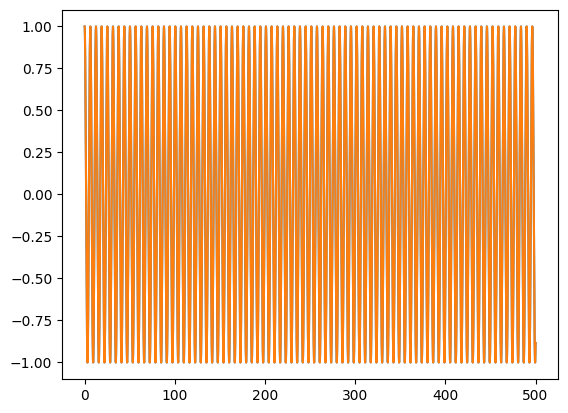

In [98]:
plt.plot(ts,xs)
plt.plot(ts,numpy.cos(ts))
plt.show()

Comparison with the true solution looks OK but is hard to see.  Let's look at the error.

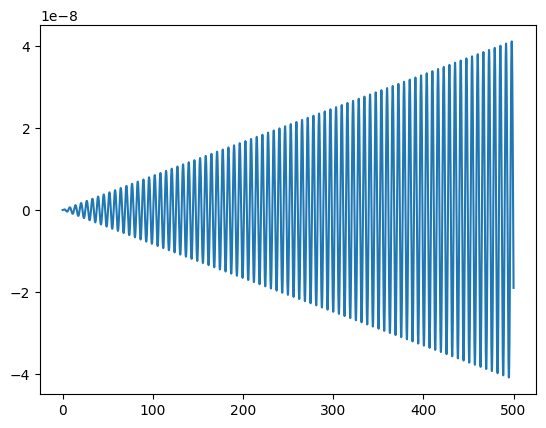

In [99]:
plt.plot(ts,xs-numpy.cos(ts))
plt.show()

There is still an error (and there will be with any scheme) but it is much smaller and growing linearly with time, not exponentially.  Better!

## Summary

- **Gotcha #1**: even though the computer can represent small numbers (1E-12) and big numbers (1E6) in memory, it may still struggle to combine them.
- **Gotcha #2**: errors can seem to come from nowhere if the conditioning of the process makes it highly sensitive.
- **Gotcha #3** simulated behaviour can be radically different than real life due to approximation by finite steps.